# Sales Data Analysis

The data consists of 100000 orders placed by customers over the date range of 2021-01-15 and 2021-06-15. 
* The following column fields are available: 
* Date -- the date an order was placed on (format YYYY-MM-DD).
* CustomerId - an alpha numeric field representing a unique customer.
* OrderId - a numeric field representing a unique order number.
* RestaurantId - a numeric field representing the restaurant that an order was placed at.

# Import libraries

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings('ignore')

# Import data

In [2]:
data = pd.read_csv('Data_Analyst_Take_Home.csv')
data.head()

,Date,CustomerId,orderid,RestaurantId
0,2021-01-30,rededuf,49087764,1280
1,2021-02-11,1deesus,50281843,1280
2,2021-02-13,1usrfdn,50515965,1280
3,2021-02-14,eeddrdn,50655182,1280
4,2021-02-15,1rr1u1n,50760529,1280


In [3]:
# Convert the date object type to datetime type
data.Date = pd.to_datetime(data.Date)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Date          100000 non-null  datetime64[ns]
 1   CustomerId    100000 non-null  object        
 2   orderid       100000 non-null  int64         
 3   RestaurantId  100000 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.1+ MB


#### Q1: Which customer id placed the fourth most orders during period?

In [5]:
# Group the data by customer
customer_order_count = data.groupby('CustomerId').agg({'orderid':[('counts','count')]})

# Drop multi-index for columns and reset index
customer_order_count.columns = customer_order_count.columns.droplevel()

# Reset the index
customer_order_count.reset_index(inplace=True)

# sort the table and return head
top_4 = customer_order_count.sort_values('counts', ascending=False).head(4)
top_4.sort_values('counts').head(1)


,CustomerId,counts
13510,1nusf12,40


#### Q2: What was the average number of orders placed by all customers over the period, rounded off to 3 decimal places?

In [6]:
orders_sum = customer_order_count.counts.sum()
customer_count = customer_order_count.CustomerId.count()
np.round(orders_sum / customer_count,3)

2.356

#### Q3: How many customers only placed 1 order during the period?

In [7]:
q = customer_order_count['counts'] == 1
customer_order_count.counts[q].sum(axis=0)

21990

#### Q4: For customers who placed at least 3 orders, what was the average number of days between their first & third order, rounded off to 3 decimal places?

In [8]:
# Customers with min 3 orders
q = customer_order_count['counts'] > 2
customers_min_3_orders = customer_order_count[q]

# Merge to get the full records
merged_min_3_orders = data.merge(customers_min_3_orders, on='CustomerId')
merged_min_3_orders

,Date,CustomerId,orderid,RestaurantId,counts
0,2021-02-11,1deesus,50281843,1280,4
1,2021-05-08,1deesus,59933839,14984,4
2,2021-04-30,1deesus,59018084,15041,4
3,2021-05-15,1deesus,60736251,15041,4
4,2021-02-13,1usrfdn,50515965,1280,10
...,...,...,...,...,...
60685,2021-03-14,1ddd2sd,53709738,1534,3
60686,2021-04-17,1ddd2sd,57436817,1534,3
60687,2021-03-19,1sddefd,54194797,14078,3
60688,2021-03-23,1sddefd,54591393,14078,3


In [9]:
# Sort the table by custermerId and Date
merged_min_3_orders = merged_min_3_orders.sort_values(['CustomerId','Date'])
merged_min_3_orders

,Date,CustomerId,orderid,RestaurantId,counts
15180,2021-01-31,11111fu,49267479,1555,3
15181,2021-04-05,11111fu,56229305,13286,3
15182,2021-05-29,11111fu,62495874,13286,3
21870,2021-02-07,1111rrr,49947494,16155,4
21871,2021-02-16,1111rrr,50791680,17265,4
...,...,...,...,...,...
32418,2021-03-20,uruuud,54350505,13132,5
32419,2021-04-23,uruuud,58206291,13169,5
59498,2021-01-18,uu2d,47907936,10751,3
59499,2021-02-03,uu2d,49490494,10751,3


In [10]:
# Add a tracking column starting at 1
merged_min_3_orders['tracker'] = 1

# Increment the tracking column for each matching customerId
merged_min_3_orders['tracker'] += merged_min_3_orders.groupby('CustomerId')['CustomerId'].cumcount()
merged_min_3_orders


,Date,CustomerId,orderid,RestaurantId,counts,tracker
15180,2021-01-31,11111fu,49267479,1555,3,1
15181,2021-04-05,11111fu,56229305,13286,3,2
15182,2021-05-29,11111fu,62495874,13286,3,3
21870,2021-02-07,1111rrr,49947494,16155,4,1
21871,2021-02-16,1111rrr,50791680,17265,4,2
...,...,...,...,...,...,...
32418,2021-03-20,uruuud,54350505,13132,5,4
32419,2021-04-23,uruuud,58206291,13169,5,5
59498,2021-01-18,uu2d,47907936,10751,3,1
59499,2021-02-03,uu2d,49490494,10751,3,2


In [11]:
# Isolate the first and third orders
q = (merged_min_3_orders['tracker'] == 1) | (merged_min_3_orders['tracker'] == 3)
first_third_orders = merged_min_3_orders[q]

first_third_orders

,Date,CustomerId,orderid,RestaurantId,counts,tracker
15180,2021-01-31,11111fu,49267479,1555,3,1
15182,2021-05-29,11111fu,62495874,13286,3,3
21870,2021-02-07,1111rrr,49947494,16155,4,1
21872,2021-05-27,1111rrr,62168598,10153,4,3
27812,2021-02-26,1112d22,51909665,12928,9,1
...,...,...,...,...,...,...
27472,2021-02-12,ursn1e,50471270,550,4,3
32416,2021-01-24,uruuud,48488836,13132,5,1
32415,2021-02-22,uruuud,51438344,17198,5,3
59498,2021-01-18,uu2d,47907936,10751,3,1


In [12]:
# Transform and join the date fields 
first_third_orders['Grouped'] = first_third_orders.groupby('CustomerId')\
                                ['Date'].transform(lambda x: ' '.join(x.astype(str)))


first_third_orders

,Date,CustomerId,orderid,RestaurantId,counts,tracker,Grouped
15180,2021-01-31,11111fu,49267479,1555,3,1,2021-01-31 2021-05-29
15182,2021-05-29,11111fu,62495874,13286,3,3,2021-01-31 2021-05-29
21870,2021-02-07,1111rrr,49947494,16155,4,1,2021-02-07 2021-05-27
21872,2021-05-27,1111rrr,62168598,10153,4,3,2021-02-07 2021-05-27
27812,2021-02-26,1112d22,51909665,12928,9,1,2021-02-26 2021-05-15
...,...,...,...,...,...,...,...
27472,2021-02-12,ursn1e,50471270,550,4,3,2021-01-28 2021-02-12
32416,2021-01-24,uruuud,48488836,13132,5,1,2021-01-24 2021-02-22
32415,2021-02-22,uruuud,51438344,17198,5,3,2021-01-24 2021-02-22
59498,2021-01-18,uu2d,47907936,10751,3,1,2021-01-18 2021-05-19


In [13]:
# Retain only the relevant info
first_third_orders = first_third_orders[['CustomerId','Grouped']]

# Drop duplicates
first_third_orders.drop_duplicates(inplace=True)

# Extract the dates and days difference
first_third_orders['Date1'] = pd.to_datetime(first_third_orders['Grouped'].str[:10])
first_third_orders['Date2'] = pd.to_datetime(first_third_orders['Grouped'].str[-10:])
first_third_orders['Days Diff'] = (first_third_orders['Date2'] - first_third_orders['Date1']).dt.days

first_third_orders

,CustomerId,Grouped,Date1,Date2,Days Diff
15180,11111fu,2021-01-31 2021-05-29,2021-01-31,2021-05-29,118
21870,1111rrr,2021-02-07 2021-05-27,2021-02-07,2021-05-27,109
27812,1112d22,2021-02-26 2021-05-15,2021-02-26,2021-05-15,78
58340,111de2r,2021-02-07 2021-03-21,2021-02-07,2021-03-21,42
6625,111dfes,2021-01-17 2021-05-16,2021-01-17,2021-05-16,119
...,...,...,...,...,...
43654,urruf1,2021-04-18 2021-05-25,2021-04-18,2021-05-25,37
17914,ursfef,2021-03-20 2021-04-20,2021-03-20,2021-04-20,31
27471,ursn1e,2021-01-28 2021-02-12,2021-01-28,2021-02-12,15
32416,uruuud,2021-01-24 2021-02-22,2021-01-24,2021-02-22,29


In [47]:
np.round(first_third_orders['Days Diff'].sum() / len(first_third_orders), 3)

50.222

#### Q5: How many customers placed MORE than 8 orders?

In [15]:
q = customer_order_count['counts'] > 8
customers_over_8_orders = customer_order_count[q]
customers_over_8_orders.CustomerId.count()

1281

#### Q6: For customers who placed at least 8 orders, what was the average number of days between their third and eighth order, rounded off to 3 decimal places?

In [16]:
# Customers with min 8 orders
q = customer_order_count['counts'] > 7
customers_min_8_orders = customer_order_count[q]

# Merge to get the full records
merged_min_8_orders = data.merge(customers_min_8_orders, on='CustomerId')

merged_min_8_orders.head()


,Date,CustomerId,orderid,RestaurantId,counts
0,2021-02-13,1usrfdn,50515965,1280,10
1,2021-02-11,1usrfdn,50272176,10767,10
2,2021-05-03,1usrfdn,59389586,10802,10
3,2021-03-14,1usrfdn,53667676,14931,10
4,2021-04-06,1usrfdn,56261573,3781,10


In [17]:
# Sort the table by custermerId and Date
merged_min_8_orders = merged_min_8_orders.sort_values(['CustomerId','Date'])
merged_min_8_orders

,Date,CustomerId,orderid,RestaurantId,counts
12167,2021-02-26,1112d22,51909665,12928,9
12164,2021-03-02,1112d22,52367205,13606,9
12168,2021-05-15,1112d22,60730409,12928,9
12169,2021-05-21,1112d22,61385326,12928,9
12170,2021-05-23,1112d22,61628928,12928,9
...,...,...,...,...,...
17687,2021-03-13,urrndr,53611682,10119,9
17688,2021-03-17,urrndr,53999907,10119,9
17689,2021-04-19,urrndr,57732137,1182,9
17690,2021-05-03,urrndr,59446117,1182,9


In [18]:
# Add a tracking column starting at 1
merged_min_8_orders['tracker'] = 1

# Increment the tracking column for each matching customerId
merged_min_8_orders['tracker'] += merged_min_8_orders.groupby('CustomerId')['CustomerId'].cumcount()
merged_min_8_orders

,Date,CustomerId,orderid,RestaurantId,counts,tracker
12167,2021-02-26,1112d22,51909665,12928,9,1
12164,2021-03-02,1112d22,52367205,13606,9,2
12168,2021-05-15,1112d22,60730409,12928,9,3
12169,2021-05-21,1112d22,61385326,12928,9,4
12170,2021-05-23,1112d22,61628928,12928,9,5
...,...,...,...,...,...,...
17687,2021-03-13,urrndr,53611682,10119,9,5
17688,2021-03-17,urrndr,53999907,10119,9,6
17689,2021-04-19,urrndr,57732137,1182,9,7
17690,2021-05-03,urrndr,59446117,1182,9,8


In [19]:
# Isolate the third and eighth order
q = (merged_min_8_orders['tracker'] == 3) | (merged_min_8_orders['tracker'] == 8)
third_eighth_orders = merged_min_8_orders[q]

third_eighth_orders

,Date,CustomerId,orderid,RestaurantId,counts,tracker
12168,2021-05-15,1112d22,60730409,12928,9,3
12165,2021-06-10,1112d22,63972579,13606,9,8
12058,2021-02-13,112fs2e,50538028,14911,12,3
12064,2021-04-09,112fs2e,56676657,473,12,8
3911,2021-02-14,112sddr,50691132,17544,12,3
...,...,...,...,...,...,...
17306,2021-06-07,unsres,63636942,3919,8,8
985,2021-03-09,urds2,53133468,4166,15,3
989,2021-04-18,urds2,57581513,11144,15,8
17686,2021-02-24,urrndr,51630499,14693,9,3


In [20]:
# Transform and join the date fields 
third_eighth_orders['Grouped'] = third_eighth_orders.groupby('CustomerId')\
                                ['Date'].transform(lambda x: ' '.join(x.astype(str)))


third_eighth_orders

,Date,CustomerId,orderid,RestaurantId,counts,tracker,Grouped
12168,2021-05-15,1112d22,60730409,12928,9,3,2021-05-15 2021-06-10
12165,2021-06-10,1112d22,63972579,13606,9,8,2021-05-15 2021-06-10
12058,2021-02-13,112fs2e,50538028,14911,12,3,2021-02-13 2021-04-09
12064,2021-04-09,112fs2e,56676657,473,12,8,2021-02-13 2021-04-09
3911,2021-02-14,112sddr,50691132,17544,12,3,2021-02-14 2021-03-31
...,...,...,...,...,...,...,...
17306,2021-06-07,unsres,63636942,3919,8,8,2021-02-23 2021-06-07
985,2021-03-09,urds2,53133468,4166,15,3,2021-03-09 2021-04-18
989,2021-04-18,urds2,57581513,11144,15,8,2021-03-09 2021-04-18
17686,2021-02-24,urrndr,51630499,14693,9,3,2021-02-24 2021-05-03


In [21]:
# Retain only the relevant info
third_eighth_orders = third_eighth_orders[['CustomerId','Grouped']]

# Drop duplicates
third_eighth_orders.drop_duplicates(inplace=True)

# Extract the dates and days difference
third_eighth_orders['Date1'] = pd.to_datetime(third_eighth_orders['Grouped'].str[:10])
third_eighth_orders['Date2'] = pd.to_datetime(third_eighth_orders['Grouped'].str[-10:])
third_eighth_orders['Days Diff'] = (third_eighth_orders['Date2'] - third_eighth_orders['Date1']).dt.days

third_eighth_orders

,CustomerId,Grouped,Date1,Date2,Days Diff
12168,1112d22,2021-05-15 2021-06-10,2021-05-15,2021-06-10,26
12058,112fs2e,2021-02-13 2021-04-09,2021-02-13,2021-04-09,55
3911,112sddr,2021-02-14 2021-03-31,2021-02-14,2021-03-31,45
15089,112sdds,2021-03-24 2021-04-19,2021-03-24,2021-04-19,26
13697,11d12un,2021-04-22 2021-05-12,2021-04-22,2021-05-12,20
...,...,...,...,...,...
7435,uddud1,2021-03-25 2021-05-28,2021-03-25,2021-05-28,64
8751,udfune,2021-01-27 2021-05-03,2021-01-27,2021-05-03,96
17312,unsres,2021-02-23 2021-06-07,2021-02-23,2021-06-07,104
985,urds2,2021-03-09 2021-04-18,2021-03-09,2021-04-18,40


In [48]:
np.round(third_eighth_orders['Days Diff'].sum() / len(third_eighth_orders),3)

56.98

#### Q7: Which date had the seventh most orders placed overall? Answer format: YYYY-MM-DD

In [23]:
date_order_count = data.groupby('Date').agg({'orderid':[('counts','count')]})

# Drop multi-index for columns and reset index
date_order_count.columns = date_order_count.columns.droplevel()
date_order_count.reset_index(inplace=True)

# sort the df by counts
top_7_date_orders_count = date_order_count.sort_values('counts', ascending=False).head(7)
top_7_date_orders_count.sort_values('counts').head(1)


,Date,counts
15,2021-01-30,1380


#### Q8: Which restaurant id had the highest number of orders placed in June 2021?

In [24]:
# Get the data for June
q = (data['Date'].dt.month == 6 )
june_data = data[q]

# Group the June data by RestaurantId and count
june_restaurant_order_count = june_data.groupby('RestaurantId').agg({'RestaurantId': [('counts','count')]})
june_restaurant_order_count.columns = june_restaurant_order_count.columns.droplevel()

# Get the highest order count
june_restaurant_order_count.sort_values('counts', ascending=False).head(1)

,counts
RestaurantId,
15001,24


#### Q9: Write & paste a python function called “ten_highest” that will take a pandas DataFrame as an argument & return a List of the 10 highest ordering customer ids for the period below. Assume that pandas has been imported under the alias pd.

In [25]:
def ten_highest(df):
    """Extracts the 10 highest ordering customer's ids. 
    
    Args:
        arg_1 (DataFrame): pandas DataFrame.

    Returns:
        List: List of ids of the 10 highest ordering customers.
    
    """
    customer_order_count = df.groupby('CustomerId').agg({'orderid':[('counts','count')]})

    # Drop multi-index for columns
    customer_order_count.columns = customer_order_count.columns.droplevel()

    # Reset the index
    customer_order_count.reset_index(inplace=True)

    # sort the table and return head
    top_10 = customer_order_count.sort_values('counts', ascending=False).head(10)

    return list(top_10.CustomerId)
    

In [26]:
ten_highest(data)

['1udns1n',
 '1ue2du2',
 '1udd2n2',
 '1nusf12',
 '1ndnues',
 '1u1f1dr',
 '1uuness',
 '1ud1sed',
 '1uesnfe',
 '1u1fnrd']

#### Q10: Assuming that the data is available as a database table called “orders”, write & paste a SQL statement that will display only the 10 restaurant ids with highest orders for the period.

In [27]:
data.head()

,Date,CustomerId,orderid,RestaurantId
0,2021-01-30,rededuf,49087764,1280
1,2021-02-11,1deesus,50281843,1280
2,2021-02-13,1usrfdn,50515965,1280
3,2021-02-14,eeddrdn,50655182,1280
4,2021-02-15,1rr1u1n,50760529,1280


In [28]:
conn = sqlite3.connect('test_database')
c = conn.cursor()

c.execute('CREATE TABLE IF NOT EXISTS orders (Date date, CustomerId text, orderid number, RestaurantId number)')
conn.commit()

data.to_sql('orders', conn, if_exists='replace', index = False)

In [29]:
c.execute('''  
SELECT RestaurantId, COUNT(*) FROM orders
GROUP BY RestaurantId
ORDER BY COUNT(*) DESC
LIMIT 10
          ''')

for row in c.fetchall():
    print (row)

(15001, 254)
(15668, 249)
(12954, 214)
(10308, 197)
(15059, 195)
(1745, 189)
(11823, 186)
(10563, 185)
(10676, 184)
(10315, 170)


# Insights Section
In this subsection, your ability to derive insights from the data is assessed. In some questions, long form answers are expected.

#### Insight Q1.0: Assuming that Mondays to Thursdays are regarded as Weekdays, Fridays to Sundays are regarded as Weekends. Which of the two periods (Weekdays or Weekends) have had the most overall orders over the period?
* Weekdays
* Weekends

In [30]:
# Create a DOW feature
data['DOW'] = data['Date'].dt.dayofweek
# Identify the period
data['Period'] = data["DOW"].apply(lambda val: 'Weekend' if val > 3 else 'Weekday' )

data.head()

,Date,CustomerId,orderid,RestaurantId,DOW,Period
0,2021-01-30,rededuf,49087764,1280,5,Weekend
1,2021-02-11,1deesus,50281843,1280,3,Weekday
2,2021-02-13,1usrfdn,50515965,1280,5,Weekend
3,2021-02-14,eeddrdn,50655182,1280,6,Weekend
4,2021-02-15,1rr1u1n,50760529,1280,0,Weekday


In [31]:
# Group by period
data.groupby('Period').agg({'Period': [('counts', 'count')]})

,Period
,counts
Period,
Weekday,50388
Weekend,49612


#### Insight Q1.1: Name 2 possible reasons why the period in Q1.0 has the most orders?

1. 
Due to the impact of Covid and the associated restrictions during 2021, South Africans may have preferred contactless fast food services. This may have contributed to the increase in home order deliveries during that period.


2. 
The idea of a weekends being reserved for take-out, as a break from routine and place, is not what it used to be. Furthermore, a broader group of South African consumers have become more technology savvy and have grown accustomed to the idea of ordering food online. This is may have contributed to the higher number of weekday, online orders.

#### Insight Q2.0: Count the number of restaurants with at least 1 order for each month over the period. Based on the calculations performed above, what type of trend do you observe in the number of restaurants with orders overtime (increasing, stable, declining)?
* Increasing
* Stable
* Declining

In [32]:
# isolate the month for each order
data['Month'] = data['Date'].dt.month

# create dummies 
data_dummies = pd.get_dummies(data['Month'])

# Concatenate this set back to the orginal DataFrame
data = pd.concat([data, data_dummies], axis=1)

# count orders per month
Restaurant_monthly_count = data.groupby('RestaurantId').agg({1:'sum',
                                 2:'sum',
                                 3:'sum',
                                 4:'sum',
                                 5:'sum',
                                 6:'sum'})

Restaurant_monthly_count 

,1,2,3,4,5,6
RestaurantId,,,,,,
3,0,2,1,0,0,0
4,3,8,4,1,4,3
6,1,3,3,0,2,0
7,1,2,1,0,1,1
11,1,2,0,2,1,1
...,...,...,...,...,...,...
18831,0,0,0,0,0,1
18835,0,0,0,0,0,1
18844,0,0,0,0,0,1


In [33]:
# Empty dictionary
monthly_order_dict = {}
# Fill dictionary with monthly orders
for m in range(1,7):
    monthly_order_dict[m] = Restaurant_monthly_count[Restaurant_monthly_count[m] != 0].count()[m]
    
monthly_order_dict

{1: 3926, 2: 4992, 3: 4561, 4: 4308, 5: 4378, 6: 3111}

Declining

#### Insight Q2.1: Name 1 reason why you reach the conclusion above?

The number of orders,  as seen here: {1: 3926, 2: 4992, 3: 4561, 4: 4308, 5: 4378, 6: 3111}, were increasing up to February but thereafter started declining. This was also confirmed by a trendline. 

#### Insight Q2.2: If you apply a straight line equation on the data in 1, at what rate / slope / gradient is the trend changing at, rounded off to 3 decimal places? Example answers: -0.562 or 1.323

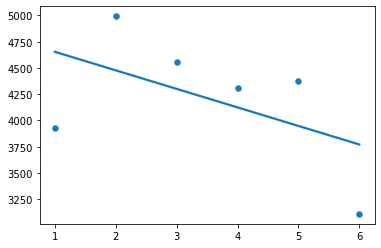

In [34]:
month = list(monthly_order_dict.keys())
orders = list(monthly_order_dict.values())


# Draw the scatter plot
sns.scatterplot(x=month,
                y=orders,
                data=monthly_order_dict)

# Draw a trend line on the scatter plot
sns.regplot(x=month,
            y=orders,
            data=monthly_order_dict,
            ci=None,
            scatter_kws={'alpha': 0.5})

# Show the plot
plt.show()

In [35]:
# Create the model object
stats_obj = ols('orders ~ month', data=monthly_order_dict)

# Fit the model
stats_obj = stats_obj.fit()

# Print the parameters of the fitted model
print(stats_obj.params)

Intercept    4829.666667
month        -176.285714
dtype: float64


#### Insight Q3.0: What is the percentage difference between the number of restaurants with orders in February 2021 & March 2021?

In [36]:
feb_rest_with_orders = Restaurant_monthly_count[Restaurant_monthly_count[2] != 0].count()[2]
mar_rest_with_orders = Restaurant_monthly_count[Restaurant_monthly_count[3] != 0].count()[3]

decrease = mar_rest_with_orders - feb_rest_with_orders
result = np.round(decrease / mar_rest_with_orders * 100, 2)
print(str(result)+'%')

-9.45%


#### Insight Q4.0: Compare the daily total orders between first 28 days of February & March 2021. What is the overall average daily difference in orders between the 2 months? Example answers: -50.6 or 201.32

In [37]:
# Isolate the first 28 days of Feb and Mar
q = ((data['Month'] == 2) | (data['Month'] == 3)) & (data['Date'].dt.day < 29)
feb_mar_daily = data[q]

# Only use the relevant features
feb_mar_daily = feb_mar_daily[['Date','CustomerId','orderid','RestaurantId','Month']]

feb_mar_daily.head()

,Date,CustomerId,orderid,RestaurantId,Month
1,2021-02-11,1deesus,50281843,1280,2
2,2021-02-13,1usrfdn,50515965,1280,2
3,2021-02-14,eeddrdn,50655182,1280,2
4,2021-02-15,1rr1u1n,50760529,1280,2
5,2021-02-25,1ddrd21,51684164,1280,2


In [38]:
# Isolate the month for each order
feb_mar_daily['Day'] = data['Date'].dt.day

# Retrieve the daily orders 
feb_mar_daily = feb_mar_daily.groupby(['Month','Day']).agg({'orderid':[('count', 'count')]})

# Drop multi index
feb_mar_daily.columns = feb_mar_daily.columns.droplevel()

# Rest index
feb_mar_daily.reset_index(inplace=True)

print(feb_mar_daily.head())
print()
print(feb_mar_daily.tail())

   Month  Day  count
0      2    1    877
1      2    2   1098
2      2    3    998
3      2    4   1193
4      2    5   1587

    Month  Day  count
51      3   24    490
52      3   25    733
53      3   26    964
54      3   27    753
55      3   28    561


In [39]:
# Transform and join the count fields 
feb_mar_daily['Grouped'] = feb_mar_daily.groupby('Day')\
                                ['count'].transform(lambda x: ','.join(x.astype(str)))

# Drop columns
feb_mar_daily.drop(['Month','count'], axis=1, inplace=True)

# Drop duplicate days
feb_mar_daily.drop_duplicates(inplace=True)

feb_mar_daily

,Day,Grouped
0,1,"877,678"
1,2,"1098,617"
2,3,"998,657"
3,4,"1193,643"
4,5,"1587,871"
5,6,"1546,712"
6,7,"1179,571"
7,8,"900,516"
8,9,"956,518"
9,10,"1017,560"


In [40]:
# Extract the sales difference
feb_mar_daily['feb'] = feb_mar_daily['Grouped'].str.split(',').str[0].astype(float)
feb_mar_daily['mar'] = feb_mar_daily['Grouped'].str.split(',').str[1].astype(float)

feb_mar_daily.head()

,Day,Grouped,feb,mar
0,1,"877,678",877.0,678.0
1,2,"1098,617",1098.0,617.0
2,3,"998,657",998.0,657.0
3,4,"1193,643",1193.0,643.0
4,5,"1587,871",1587.0,871.0


In [41]:
# Calculate the % daily decrease
feb_mar_daily['difference'] = ((feb_mar_daily['feb'] - feb_mar_daily['mar']) / feb_mar_daily['feb']) * -100

feb_mar_daily

,Day,Grouped,feb,mar,difference
0,1,"877,678",877.0,678.0,-22.690992
1,2,"1098,617",1098.0,617.0,-43.806922
2,3,"998,657",998.0,657.0,-34.168337
3,4,"1193,643",1193.0,643.0,-46.102263
4,5,"1587,871",1587.0,871.0,-45.116572
5,6,"1546,712",1546.0,712.0,-53.945666
6,7,"1179,571",1179.0,571.0,-51.569126
7,8,"900,516",900.0,516.0,-42.666667
8,9,"956,518",956.0,518.0,-45.815900
9,10,"1017,560",1017.0,560.0,-44.936087


In [42]:
print('The overall average daily difference in orders is:')
np.round(feb_mar_daily['difference'].sum() / 28, 2)

The overall average daily difference in orders is:


-31.51